In [4]:
%matplotlib inline
#https://romanorac.github.io/machine/learning/2019/09/27/time-series-prediction-with-lstm.html
import glob
from platform import python_version

import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch 

#pip3 install https://download.pytorch.org/whl/cu90/torch-1.1.0-cp37-cp37m-win_amd64.whl

import matplotlib.pyplot as plt

plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab

In [8]:
files = sorted(glob.glob('marketdata/bitmex/*.csv.gz'))
df = pd.concat(map(pd.read_csv, files))
df.shape

(12470895, 10)

In [10]:
df = df[df.symbol == 'XBTUSD']
df.timestamp = pd.to_datetime(df.timestamp.str.replace('D', 'T'))
df = df.sort_values('timestamp')
df.set_index('timestamp', inplace=True)
df.head()
#We are going to use 3 columns: timestamp, price and foreignNotional.

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2019-10-14 00:00:02.993748,XBTUSD,Buy,9,8278.0,ZeroPlusTick,4dbd315a-a23b-fef5-9e22-0ef8c1158128,108720,0.001087,9.0
2019-10-14 00:00:03.009085,XBTUSD,Buy,37,8278.0,ZeroPlusTick,c05bcbf6-c556-c4e5-c314-9b08c5e63039,446960,0.004470,37.0
2019-10-14 00:00:03.020494,XBTUSD,Buy,930,8278.0,ZeroPlusTick,767f1d5f-fe52-ebde-6286-0ad46be1d915,11234400,0.112344,930.0
2019-10-14 00:00:03.037252,XBTUSD,Sell,1,8277.5,ZeroMinusTick,637b1eb3-a2a5-4070-8330-4a6f6e28ac84,12081,0.000121,1.0
2019-10-14 00:00:03.037252,XBTUSD,Sell,1,8277.5,ZeroMinusTick,50026164-bad5-0dd4-c2a6-f4815363b204,12081,0.000121,1.0


In [11]:
df_vwap = df.groupby(pd.Grouper(freq="1Min")).apply(
    lambda row: pd.np.sum(row.price * row.foreignNotional) / pd.np.sum(row.foreignNotional)
)
df_vwap.shape

(20160,)

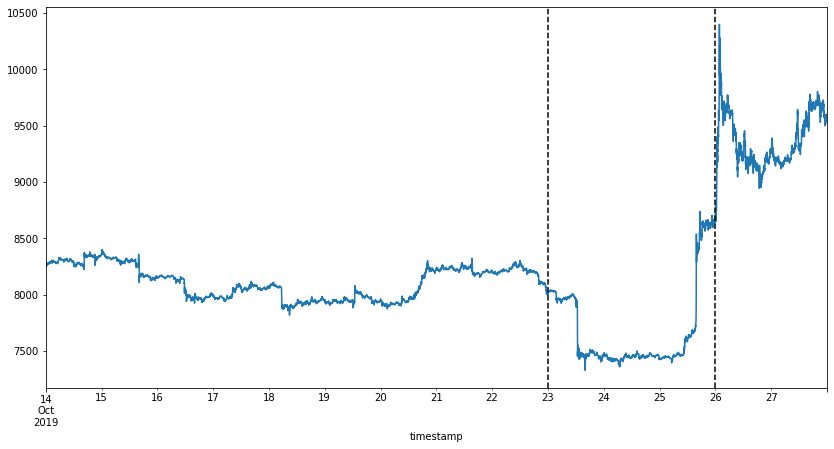

In [17]:
ax = df_vwap.plot(figsize=(14, 7))
ax.axvline("2019-10-23", linestyle="--", c="black")
ax.axvline("2019-10-26", linestyle="--", c="black")

the first part of the data for the training set, part in-between for validation set and the last part of the data for the test set (vertical lines are delimiters). We can observe volatility in the VWAP, where the price reaches its highs in the first part of August and lows at the end of August. The high and low are captured in the training set, which is important, as the model most probably wouldn’t work well on unseen VWAP intervals.

In [21]:
df_train = df_vwap[df_vwap.index < "2019-10-23"].to_frame(name="vwap")
df_train.shape

(12960, 1)

In [24]:
df_train.head()

,vwap
timestamp,
2019-10-14 00:00:00,8276.846772
2019-10-14 00:01:00,8270.661678
2019-10-14 00:02:00,8265.244021
2019-10-14 00:03:00,8259.053885
2019-10-14 00:04:00,8257.609670


In [22]:
df_val = df_vwap[(df_vwap.index >= "2019-10-23") & (df_vwap.index < "2019-10-26")].to_frame(name="vwap")
df_val.shape

(4320, 1)

In [23]:
df_test = df_vwap[df_vwap.index >= "2019-10-26"].to_frame(name='vwap')
df_test.shape

(2880, 1)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

In [26]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

from torch.autograd import Variable

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

In [30]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [31]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [32]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

In [33]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: 0.53. Validation loss: 6.81. Avg future: 0.00. Elapsed time: 17.72s.
Epoch 2 Train loss: 0.06. Validation loss: 6.20. Avg future: 0.00. Elapsed time: 16.35s.
Epoch 3 Train loss: 0.04. Validation loss: 5.45. Avg future: 0.00. Elapsed time: 15.17s.
Epoch 4 Train loss: 0.03. Validation loss: 4.94. Avg future: 0.00. Elapsed time: 15.82s.
Epoch 5 Train loss: 0.02. Validation loss: 4.49. Avg future: 0.00. Elapsed time: 15.94s.
Epoch 6 Train loss: 0.02. Validation loss: 4.58. Avg future: 0.00. Elapsed time: 15.73s.
Epoch 7 Train loss: 0.02. Validation loss: 4.55. Avg future: 0.00. Elapsed time: 15.21s.
Epoch 8 Train loss: 0.02. Validation loss: 4.52. Avg future: 0.00. Elapsed time: 16.23s.
Epoch 9 Train loss: 0.02. Validation loss: 4.48. Avg future: 0.00. Elapsed time: 16.17s.
Epoch 10 Train loss: 0.01. Validation loss: 4.43. Avg future: 0.00. Elapsed time: 17.06s.
Epoch 11 Train loss: 0.01. Validation loss: 4.43. Avg future: 0.00. Elapsed time: 16.81s.
Epoch 12 Train loss

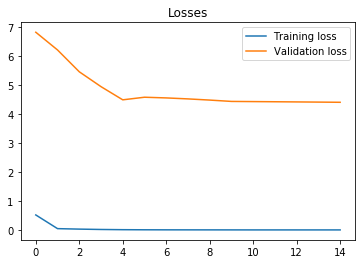

In [34]:
optimization_1.plot_losses()

Test loss 50.6742


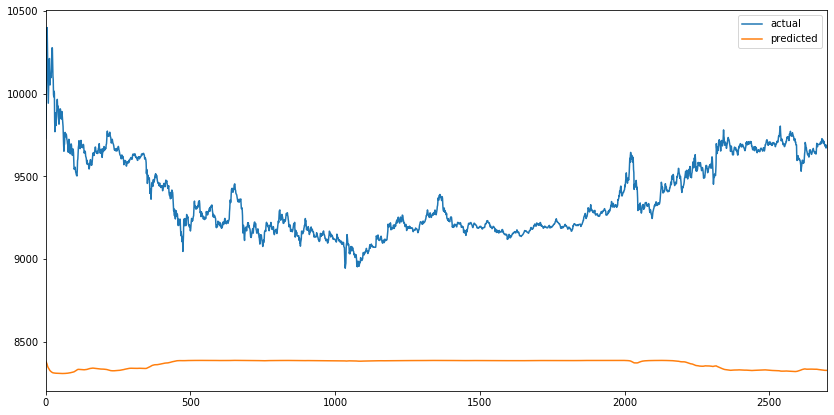

In [35]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)